In [1]:
# number of CPUs to be used
NCPU=20

## Load and process the dataset

In [2]:
import gzip, json
import numpy as np
import utils 
from sklearn.model_selection import train_test_split

# 20 standard amino acids
aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

# load
dataset = utils.load_phipsi()

# 90% train, 10% test
train,test = train_test_split(dataset, test_size=0.1, random_state=42)


## Randomness in clustering

K-means clustering is not guarantied to converge to the best  global solution each time you run it, but rather gives you a local suboptimal splitting. To check how this randomness in the k-means clusters affects the full angle prediction pipeline, we repeat clustering-training-testing procedure multiple times (number of clusters is fixed to 15) and compare the results.

In [3]:
WINDOW = 15

# do not need to change X (1-hot-encoded sequence)
# so can set it only once
X_train = utils.getX(train, WINDOW)
X_test = utils.getX(test, WINDOW)

# reference phi,psi for the test set
# also do not change
phi_ref = utils.getPHI(test, WINDOW)
psi_ref = utils.getPSI(test, WINDOW)


In [4]:
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

WINDOW = 15

# number of times clustering-learning-testing pipeline
# will be repeated
niter = 15

# save all clustering results here
KMEANS = []
scores1 = []

for i in range(niter):
    
    # cluster
    KM = KMeans(n_clusters=20, max_iter=5, n_jobs=NCPU)
    KM.fit(np.vstack([item['avec'] for item in train]))
    
    # save current solution
    KMEANS.append(KM)
    
    # update Y vectors (cluster IDs for central residues)
    Y_train = utils.getY(train, WINDOW, KM)
    Y_test = utils.getY(test, WINDOW, KM)
    
    # train logistic regression model
    sgd = SGDClassifier(max_iter=10, tol=1e-3, loss='log', n_jobs=NCPU)
    sgd.fit(X_train, Y_train)
    
    # calculate sin(.),cos(.) weighted averages on the test set
    avec = np.matmul(sgd.predict_proba(X_test), KM.cluster_centers_)

    # convert angle vectors to true angles
    norm_phi = np.sqrt(np.square(avec[:,0])+np.square(avec[:,1]))
    norm_psi = np.sqrt(np.square(avec[:,2])+np.square(avec[:,3]))
    phi_pred = np.arctan2(avec[:,0] / norm_phi, avec[:,1] / norm_phi)
    psi_pred = np.arctan2(avec[:,2] / norm_psi, avec[:,3] / norm_psi)

    # calculate scores
    loss = log_loss(Y_test, sgd.predict_proba(X_test))
    rmse_phi = utils.ang_rmse(phi_ref, phi_pred) * 180 / np.pi
    rmse_psi = utils.ang_rmse(psi_ref, psi_pred) * 180 / np.pi
    
    scores1.append([rmse_phi, rmse_psi, loss])
    
    print("iter {:2d} | loss {:.5f} | rmse(phi) {:9.5f} | rmse(phi) {:9.5f}".
          format(i, loss, rmse_phi, rmse_psi))

iter  0 | loss 2.29901 | rmse(phi)  43.79000 | rmse(phi)  87.44794
iter  1 | loss 2.27699 | rmse(phi)  43.86650 | rmse(phi)  87.42409
iter  2 | loss 2.24446 | rmse(phi)  44.57573 | rmse(phi)  86.84873
iter  3 | loss 2.24520 | rmse(phi)  43.90762 | rmse(phi)  87.39034
iter  4 | loss 2.27430 | rmse(phi)  44.20155 | rmse(phi)  86.84490
iter  5 | loss 2.30275 | rmse(phi)  43.93875 | rmse(phi)  87.40062
iter  6 | loss 2.26407 | rmse(phi)  43.93802 | rmse(phi)  87.12427
iter  7 | loss 2.13245 | rmse(phi)  44.47611 | rmse(phi)  87.42718
iter  8 | loss 2.24313 | rmse(phi)  44.88419 | rmse(phi)  87.15985
iter  9 | loss 2.17898 | rmse(phi)  44.35646 | rmse(phi)  87.61731
iter 10 | loss 2.10362 | rmse(phi)  44.02227 | rmse(phi)  87.42052
iter 11 | loss 2.14396 | rmse(phi)  44.67547 | rmse(phi)  87.05030
iter 12 | loss 2.30186 | rmse(phi)  43.77063 | rmse(phi)  87.10929
iter 13 | loss 2.25184 | rmse(phi)  44.07783 | rmse(phi)  87.29353
iter 14 | loss 2.28005 | rmse(phi)  44.78594 | rmse(phi)  86.8

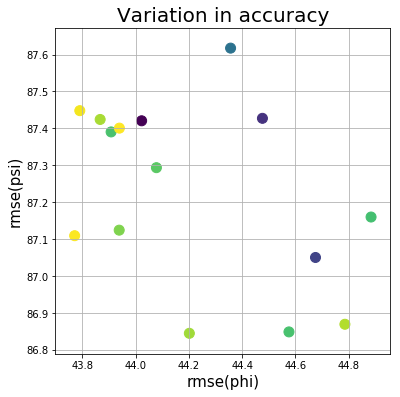

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

xyc = np.array(scores1)

plt.figure(figsize=(6,6))
plt.xlabel('rmse(phi)', fontsize=15)
plt.ylabel('rmse(psi)', fontsize=15)
plt.grid()
plt.rc('axes', axisbelow=True)
plt.title('Variation in accuracy', fontsize=20)
plt.scatter(xyc[:,0], xyc[:,1], c=xyc[:,2], s=100)
plt.show()


## Effect of window size

In [6]:
# select the first cluster
KM = KMEANS[0]

scores2 = []

for WINDOW in range(1,32,2):
    
    # WINDOW changes, so does X
    X_train = utils.getX(train, WINDOW)
    X_test = utils.getX(test, WINDOW)
    
    # update Y vectors (cluster IDs for central residues)
    Y_train = utils.getY(train, WINDOW, KM)
    Y_test = utils.getY(test, WINDOW, KM)
    
    # same for reference angles
    phi_ref = utils.getPHI(test, WINDOW)
    psi_ref = utils.getPSI(test, WINDOW)

    # train logistis regression model
    sgd = SGDClassifier(max_iter=10, tol=1e-3, loss='log', n_jobs=NCPU)
    sgd.fit(X_train, Y_train)
    
    # calculate sin(.),cos(.) weighted averages on the test set
    avec = np.matmul(sgd.predict_proba(X_test), KM.cluster_centers_)

    # convert angle vectors to true angles
    norm_phi = np.sqrt(np.square(avec[:,0])+np.square(avec[:,1]))
    norm_psi = np.sqrt(np.square(avec[:,2])+np.square(avec[:,3]))
    phi_pred = np.arctan2(avec[:,0] / norm_phi, avec[:,1] / norm_phi)
    psi_pred = np.arctan2(avec[:,2] / norm_psi, avec[:,3] / norm_psi)

    # calculate scores
    loss = log_loss(Y_test, sgd.predict_proba(X_test))
    rmse_phi = utils.ang_rmse(phi_ref, phi_pred) * 180 / np.pi
    rmse_psi = utils.ang_rmse(psi_ref, psi_pred) * 180 / np.pi
    
    scores2.append([WINDOW, rmse_phi, rmse_psi, loss])
    
    print("WINDOW {:2d} | loss {:.5f} | rmse(phi) {:9.5f} | rmse(phi) {:9.5f}".
          format(WINDOW, loss, rmse_phi, rmse_psi))
    

WINDOW  1 | loss 2.49156 | rmse(phi)  45.06750 | rmse(phi)  93.87474
WINDOW  3 | loss 2.39375 | rmse(phi)  44.43677 | rmse(phi)  92.37205
WINDOW  5 | loss 2.35245 | rmse(phi)  44.21429 | rmse(phi)  90.35224
WINDOW  7 | loss 2.32653 | rmse(phi)  44.01927 | rmse(phi)  89.26407
WINDOW  9 | loss 2.31272 | rmse(phi)  44.20064 | rmse(phi)  88.78863
WINDOW 11 | loss 2.30531 | rmse(phi)  44.33077 | rmse(phi)  88.11443
WINDOW 13 | loss 2.30077 | rmse(phi)  44.22622 | rmse(phi)  87.59582
WINDOW 15 | loss 2.29822 | rmse(phi)  43.97637 | rmse(phi)  87.44025
WINDOW 17 | loss 2.29793 | rmse(phi)  44.32336 | rmse(phi)  87.28400
WINDOW 19 | loss 2.29790 | rmse(phi)  44.32771 | rmse(phi)  87.28814
WINDOW 21 | loss 2.29904 | rmse(phi)  44.17944 | rmse(phi)  86.65857
WINDOW 23 | loss 2.30018 | rmse(phi)  44.14231 | rmse(phi)  87.18082
WINDOW 25 | loss 2.30087 | rmse(phi)  44.23421 | rmse(phi)  86.93440
WINDOW 27 | loss 2.30406 | rmse(phi)  44.46767 | rmse(phi)  87.44355
WINDOW 29 | loss 2.30433 | rmse(ph

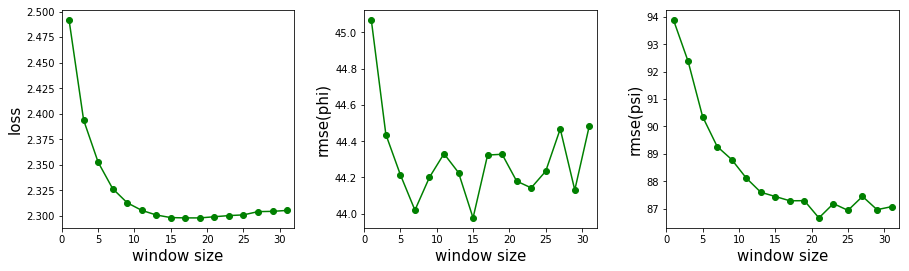

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 4)

xyc = np.array(scores2)

# set style
for col in (0,1,2):
    ax[col].set_xlim([0,32])
    ax[col].set_xlabel("window size", fontsize=15)

ax[0].set_ylabel("loss", fontsize=15)
ax[0].plot(xyc[:,0], xyc[:,3], linestyle='-', marker='o', color='g')

ax[1].set_ylabel("rmse(phi)", fontsize=15)
ax[1].plot(xyc[:,0], xyc[:,1], linestyle='-', marker='o', color='g')

ax[2].set_ylabel("rmse(psi)", fontsize=15)
ax[2].plot(xyc[:,0], xyc[:,2], linestyle='-', marker='o', color='g')

plt.subplots_adjust(wspace = 0.3)

plt.show()

## Number of clusters

## Regularization strength